In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
app_train = pd.read_csv('Data/application_train.csv')
app_test = pd.read_csv('Data/application_test.csv')

In [3]:
combine_data = [app_train, app_test]

In [4]:
print('Training data shape:', app_train.shape)
print('Test data shape:', app_test.shape)

Training data shape: (307511, 122)
Test data shape: (48744, 121)


### Exploratory Data Analysis

In [5]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

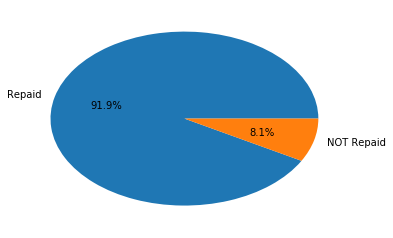

In [6]:
# Pie chart for data distribution
labels = ['Repaid', 'NOT Repaid']
size = [app_train['TARGET'].value_counts()[0], app_train['TARGET'].value_counts()[1]]
plt.pie(size, labels = labels, autopct = '%1.1f%%')
plt.show()

In [7]:
def missing_values_table(df):
    
    #Create a table containing missing value information
    mis_val = df.isnull().sum()
    mis_val_percent = mis_val * 100 / len(df)
    mis_val_table = pd.concat((mis_val, mis_val_percent), axis = 1)
    #print(mis_val_table)
    
    mis_val_table = mis_val_table[mis_val_table.iloc[:,1] != 0]
    mis_val_table = mis_val_table.rename(columns = {0: 'Missing Values', 1: '% of Total Values'})
    mis_val_table = mis_val_table.sort_values('% of Total Values', ascending = False).round(1)
    
    print('There are total', df.shape[1], 'columns.')
    print(mis_val_table.shape[0], 'of them have missing values.')
    return mis_val_table

In [8]:
missing_values = missing_values_table(app_train)

There are total 122 columns.
67 of them have missing values.


In [9]:
missing_values.head()

,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4


### Column types

In [10]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [11]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### Using One-Hot Encoding to convert object type features into trainable values.

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le_count = 0

for col in app_train:
    if app_train[col].dtype == 'object':
        #print(app_train[col].nunique())
        if app_train[col].nunique() <= 2:
            le.fit(app_train[col].astype(str))
            app_train[col] = le.transform(app_train[col].astype(str))
            app_test[col] = le.transform(app_test[col].astype(str))  
            le_count += 1
print(f'{le_count} columns were label encoded.')        

4 columns were label encoded.


### Aligning Training and Testing data

In [13]:
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape:', app_train.shape)
print('Test Features shape:', app_test.shape)

Training Features shape: (307511, 242)
Test Features shape: (48744, 238)


In [14]:
train_label = app_train['TARGET']

app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

app_train['TARGET'] = train_label

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 239)
Testing Features shape:  (48744, 238)


### Exploring Anomalies

In [15]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [16]:
(app_train['DAYS_EMPLOYED'] / -365).describe()

count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

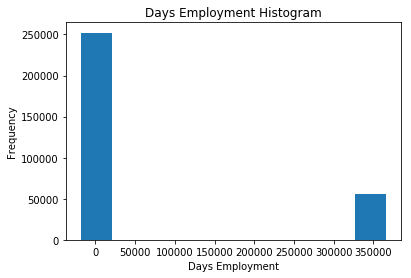

In [17]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')
plt.show()

In [18]:
len(app_train[app_train['DAYS_EMPLOYED'] > 300000])

55374

### Filling anomalies with np.nan and adding a new column indicating whether the record is anomalous or not.

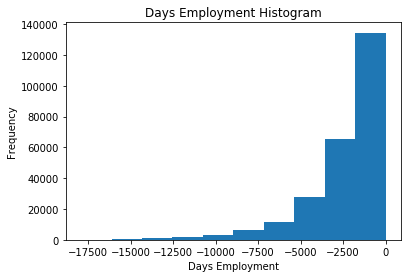

In [19]:
app_train['DAYS_EMPLOYED_ANOM'] = app_train['DAYS_EMPLOYED'] > 300000
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')
plt.show()

### Operations on test set.

In [20]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test['DAYS_EMPLOYED'] > 300000
app_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

In [21]:
print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


### Other day-related data

In [22]:
Days_col = [col for col in app_train.columns if 'DAYS' in col]
Days_col.remove('DAYS_EMPLOYED_ANOM')

In [23]:
for col in Days_col:
    print((app_train[col] / -365).describe())
    print('\n')

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64


count    252137.000000
mean          6.531971
std           6.406466
min          -0.000000
25%           2.101370
50%           4.515068
75%           8.698630
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64


count    307511.000000
mean         13.660604
std           9.651743
min          -0.000000
25%           5.506849
50%          12.339726
75%          20.491781
max          67.594521
Name: DAYS_REGISTRATION, dtype: float64


count    307511.000000
mean          8.203294
std           4.135481
min          -0.000000
25%           4.712329
50%           8.915068
75%          11.778082
max          19.717808
Name: DAYS_ID_PUBLISH, dtype: float64


count    307510.000000
mean          2.637969
std           2.265229
min          -0.000000
25%           0.7

### Now, all days-related data are in a reasonable range.

### Explore the correlation between TARGET and features.

In [24]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))

print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [25]:
# Convert birthday into a positive number. Then the correlation should become negative.
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982694

In [26]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


Text(0.5,1,'Correlation Heatmap')

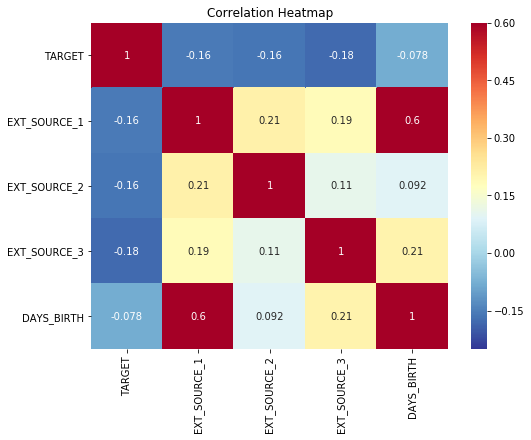

In [27]:
plt.figure(figsize = (8,6))

sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

### Fearue Engineering
#### 1. Ploynomial Features

In [28]:
# Make a new dataframe with those just those important features.
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

# Seperate target and features
poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns = ['TARGET'])

# Impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures

# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [29]:
# Train the polynomial features
poly_transformer.fit(poly_features)

#Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape:', poly_features.shape)

Polynomial Features shape: (307511, 35)


In [30]:
# Check the correlation between those made features and target.
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))
poly_features['TARGET'] = poly_target

poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


In [31]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))
# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 274)
Testing data with polynomial features shape:   (48744, 274)


#### 2. Domain Knowledge Features

* CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
* ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
* CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due
* DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

In [32]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

In [33]:
# 3 database now we have are: app_train, app_train_poly, app_train_domain
app_train.head(2)

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,TARGET,DAYS_EMPLOYED_ANOM
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0,0,0,0,0,0,1,0,1,False
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0,1,0,0,0,0,0,0,0,False


In [34]:
app_train_poly.head(2)

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,EXT_SOURCE_2^3,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,DAYS_BIRTH^3
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0.018181,0.009637,654.152107,0.005108,346.733022,2.353667e+07,0.002707,183.785678,1.247560e+07,8.468590e+11
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0.240927,0.207254,6491.237078,0.178286,5583.975307,1.748916e+08,0.153368,4803.518937,1.504475e+08,4.712058e+12


In [35]:
app_train_domain.head(2)

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,TARGET,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0,0,1,0,1,False,2.007889,0.121978,0.060749,-0.067329
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0,0,0,0,0,False,4.790750,0.132217,0.027598,-0.070862


### Implementation of Baseline models

In [36]:
from utils.preprocessing import Pre_train_processing

train_set = [app_train, app_train_poly, app_train_domain]
test_set = [app_test, app_test_poly, app_test_domain]

for i in range(len(train_set)):
    if 'TARGET' in train_set[i].columns:
        train_set[i] = train_set[i].drop(columns = ['TARGET'])
    if train_set[i].shape[1] != test_set[i].shape[1]:
        print('Train and test set have different feature dimensions.')

In [37]:
train_labels = app_train['TARGET']
train_labels.shape

(307511,)

In [38]:
for i in range(len(train_set)):
    train_set[i], test_set[i] = Pre_train_processing(train = train_set[i], test = test_set[i])

Training data shape:  (307511, 239)
Testing data shape:  (48744, 239)
Training data shape:  (307511, 274)
Testing data shape:  (48744, 274)
Training data shape:  (307511, 243)
Testing data shape:  (48744, 243)


In [39]:
from utils.Models import cv_5_default_models

for i in range(len(train_set)):
    cv_5_default_models(X = train_set[i], y = train_labels, test_X = test_set[i], app_test = app_test)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


5 fold CV accuracy for log_reg is 0.92 (+/- 0.000256)
5 fold CV ROC_AUC for log_reg is 0.75 (+/- 0.01)


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.6s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.7s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.6s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.5s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parall

5 fold CV accuracy for random_forest is 0.92 (+/- 0.000056)


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.6s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.7s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.6s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.6s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parall

5 fold CV ROC_AUC for random_forest is 0.71 (+/- 0.01)


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.5s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.3s finished
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

5 fold CV accuracy for xgb is 0.92 (+/- 0.002584)
5 fold CV ROC_AUC for xgb is 0.76 (+/- 0.01)
5 fold CV accuracy for log_reg is 0.92 (+/- 0.000232)
5 fold CV ROC_AUC for log_reg is 0.75 (+/- 0.01)


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.6s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.6s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.0s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.8s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parall

5 fold CV accuracy for random_forest is 0.92 (+/- 0.000288)


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.8s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.8s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.8s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.8s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parall

5 fold CV ROC_AUC for random_forest is 0.71 (+/- 0.01)


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   35.3s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.2s finished
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

5 fold CV accuracy for xgb is 0.92 (+/- 0.000369)
5 fold CV ROC_AUC for xgb is 0.76 (+/- 0.01)
5 fold CV accuracy for log_reg is 0.92 (+/- 0.000214)
5 fold CV ROC_AUC for log_reg is 0.75 (+/- 0.00)


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.4s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.2s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.2s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.4s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parall

5 fold CV accuracy for random_forest is 0.92 (+/- 0.000086)


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.1s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.2s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.3s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.5s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parall

5 fold CV ROC_AUC for random_forest is 0.71 (+/- 0.01)


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.2s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.3s finished
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

5 fold CV accuracy for xgb is 0.92 (+/- 0.000361)
5 fold CV ROC_AUC for xgb is 0.77 (+/- 0.01)
